In [4]:
import cv2 as cv
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [31]:
def searchImg(haystack_img, needle_img, threshold):
    result = cv.matchTemplate(haystack_img, needle_img, cv.TM_CCOEFF_NORMED)

    threshold = 0.7
    locations = np.array(np.where(result >= threshold))

    # Filtering for when it gets the same square multiple times
    height = needle_img.shape[0]
    diffs = np.diff(locations[0])
    indices = np.where(diffs > height)[0]

    # No matches were found
    if len(indices) == 0:
        return None

    selected_indices = np.concatenate(([0], indices+1))
    locations = locations[:, selected_indices]

    locations = list(zip(*locations[::-1]))

    return np.array(locations)

def getQuestionRegions(haystack, locations_black_square, locations_question):
    haystack_width, haystack_height = haystack.shape[1], haystack.shape[0]
    regions = []

    for loc_square in locations_black_square:
        for loc_quest in locations_question:
            if loc_quest[1] > loc_square[1]:
                regions.append([loc_square, loc_quest])
                break

    # Adding from the last question to the end of the page
    regions.append([locations_black_square[-1], np.array([haystack_width, haystack_height])])
    
    return regions

def trimWhitespace(image):
    # Convert to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Apply a binary threshold to detect non-white regions
    _, thresh = cv.threshold(gray, 240, 255, cv.THRESH_BINARY_INV)

    # Find contours of the non-white regions
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get bounding box of the largest contour
        x, y, w, h = cv.boundingRect(np.concatenate(contours))

        # Crop the image using the bounding box
        cropped = image[y:y+h, x:x+w]
        return cropped

def extractRegions(regions, haystack_img, needle_width, needle_height):
    haystack_width = haystack_img.shape[1]
    
    extracted_regions = []

    c = 0
    for reg_start, reg_end in regions:
        # top_left = (reg_start[0] + int(1.1*needle_width), reg_start[1] - 4*needle_height//5)
        top_left = (reg_start[0], reg_start[1] - 4*needle_height//5)
        bottom_right = (reg_start[0] + 3*haystack_width//4, reg_end[1] - needle_height//2)


        # Extract the region of interest (ROI) from the original image
        region_ = trimWhitespace(haystack_img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]])
        
        extracted_regions.append(region_)
        
    return extracted_regions

def getWhiteIntervals(img):
    # Convert to grayscale
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a binary threshold to detect non-white regions
    _, img_thr = cv.threshold(img, 240, 255, cv.THRESH_BINARY_INV)

    intervals = []

    start = None
    end = None

    for c, line in enumerate(img_thr):

        if start is None:
            if np.sum(line) == 0:
                    start = c
        elif end is None:
            if np.sum(line) != 0:
                end = c-1
                intervals.append([start, end])
                start = None
                end = None

    return intervals

def splitLines(img):
    needle_height = img.shape[0]
    needle_width = img.shape[1]
    
    intervals = getWhiteIntervals(img)
    intervals.insert(0, [-1, 0])
    intervals.append([needle_height, -1])

    quest_intervals = [[intervals[inter][1], intervals[inter+1][0]] for inter in range(len(intervals)-1)]

    # Get only the 5 greatest intervals
    if len(quest_intervals) > 5:
        intervals_size = []
        for interval_ in quest_intervals:
            diff = abs(interval_[0] - interval_[1])
            intervals_size.append(diff)
        
        intervals_size = np.array(intervals_size)
        intervals_size = np.argsort(intervals_size)[-5:][::-1]

        new_intervals = []

        for c, interval_ in enumerate(quest_intervals):
            if (c==0) or (c in intervals_size): 
                new_intervals.append(interval_)
            else:
                new_intervals[-1][1] = interval_[1]   
        quest_intervals = new_intervals

    splitted_img = []

    for inter in quest_intervals:
        img_ = img[inter[0]:inter[1], 0:needle_width]
        img_ = trimWhitespace(img_)
        splitted_img.append(img_)

    return splitted_img

def processQuestions(img, needle_width, pad=15):
    white_strip = np.full((pad, img.shape[1], 3), 255, dtype=np.uint8)
    new_image = np.vstack((img, white_strip))
    return new_image[:, int(1.1*needle_width):] 

def rewritePage(haystack, regions, quest_items, height_step=50):
    haystack_width = haystack.shape[1]
    positions = []
    for region, quest in zip(regions, quest_items):
        haystack[region[0][1]-height_step:region[1][1], region[0][0]:haystack_width] = (255, 255, 255)
        
        positions_list = [i for i in range(len(quest))]
        paired_list = list(zip(quest, positions_list))
        np.random.shuffle(paired_list)
        shuffle_quest, positions_list = zip(*paired_list)
        positions.append(list(positions_list))

        y_offset = region[0][1]
        for c, quest_ in enumerate(shuffle_quest):
            h, w = quest_.shape[:2]

            haystack[y_offset:y_offset+h, region[0][0]:region[0][0]+w] = quest_
            y_offset += h

    return haystack, positions

In [120]:
needle_img = cv.imread("data/Black_square_new.jpg", cv.IMREAD_COLOR)
needle_height = needle_img.shape[0]
needle_width = needle_img.shape[1]

questao_img = cv.imread("data/2024-Questao.jpg", cv.IMREAD_UNCHANGED)
questao_img = cv.cvtColor(questao_img, cv.COLOR_BGRA2BGR)

total_pages = len(os.listdir("data/splitted_pages-2024-1/"))
new_pages = []
new_positions = []


haystack_img = cv.imread(f"data/splitted_pages-2024-1/output_004.jpg", cv.IMREAD_COLOR)
print(f"data/splitted_pages-2024-1/output_002.jpg")
haystack_width = haystack_img.shape[1]
haystack_height = haystack_img.shape[0]

# searchImg returns None if no match was found
locations_black_square = searchImg(haystack_img, needle_img, 0.7)
if not isinstance(locations_black_square, np.ndarray):
    new_pages.append(haystack_img)
    new_positions.append(None)

locations_questao = searchImg(haystack_img, questao_img, 0.7)
if not isinstance(locations_questao, np.ndarray):
    new_pages.append(haystack_img)
    new_positions.append(None)

print(locations_black_square)

# Getting the regions of interest
regions = getQuestionRegions(haystack_img, locations_black_square, locations_questao)

# Getting the actual images from those regions
regions_extracted = extractRegions(regions, haystack_img, needle_width, needle_height)

data/splitted_pages-2024-1/output_002.jpg
[[ 388 1000]
 [ 388 1929]
 [1294 2621]]


In [121]:
cv2.imwrite("test.jpg", regions_extracted[0])

True

In [113]:
import numpy as np
import cv2 as cv

def getVerticalWhiteIntervals(img, threshold=1):
    # Convert to grayscale
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a binary threshold to detect non-white regions
    _, img_thr = cv.threshold(img, 240, 255, cv.THRESH_BINARY_INV)

    intervals = []

    start = None
    width = img_thr.shape[1]

    # Iterate over columns
    for col in range(width):
        column = img_thr[:, col]
        if start is None:
            if np.sum(column) == 0:
                start = col
        else:
            if np.sum(column) != 0:
                end = col - 1
                if (end - start + 1) >= threshold:
                    intervals.append([start, end])
                start = None

    # Handle last interval
    if start is not None:
        end = width - 1
        if (end - start + 1) >= threshold:
            intervals.append([start, end])

    return intervals

def splitVerticalLines(img, threshold=1):
    height, width = img.shape[:2]
    
    intervals = getVerticalWhiteIntervals(img, threshold=threshold)
    intervals.insert(0, [-1, 0])
    intervals.append([width, -1])

    split_intervals = [[intervals[i][1], intervals[i+1][0]] for i in range(len(intervals) - 1)]

    # Keep only the 5 widest intervals
    if len(split_intervals) > 5:
        sizes = [abs(end - start) for start, end in split_intervals]
        largest_indices = np.argsort(sizes)[-5:][::-1]

        new_intervals = []
        for i, interval in enumerate(split_intervals):
            if (i == 0) or (i in largest_indices):
                new_intervals.append(interval)
            else:
                new_intervals[-1][1] = interval[1]
        split_intervals = new_intervals

    split_images = []
    for start, end in split_intervals:
        sub_img = img[:, start:end]
        sub_img = trimWhitespace(sub_img)
        split_images.append(sub_img)

    return split_images

def splitGridLines(img, threshold=100):
    splitted_lines = splitVerticalLines(img, threshold)

    all_lines = []
    for line in splitted_lines:
        horizontal = splitLines(line)
        all_lines += horizontal

    return all_lines

In [122]:
img = cv2.imread("test.jpg")

In [123]:
all_lines = splitGridLines(img)

In [91]:
cv2.imwrite("test1.jpg", all_lines[0])

True

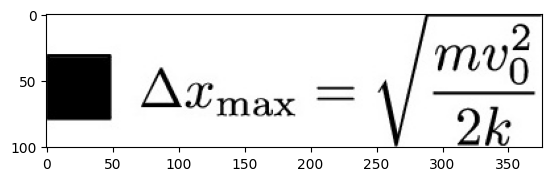

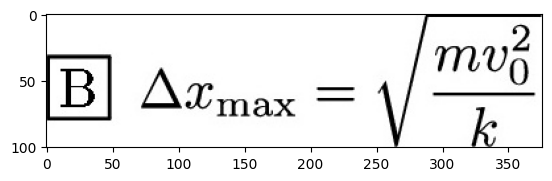

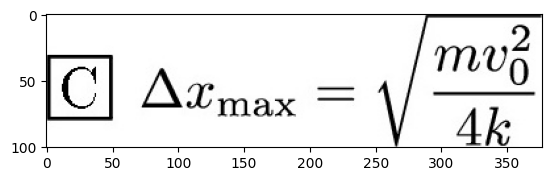

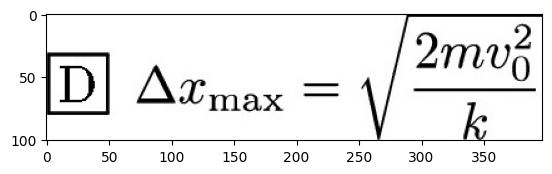

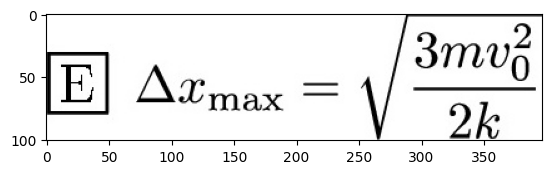

In [124]:
# splitted_lines = splitVerticalLines(img, 100)

for img in all_lines:
    img_ = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.show()

(463, 485)


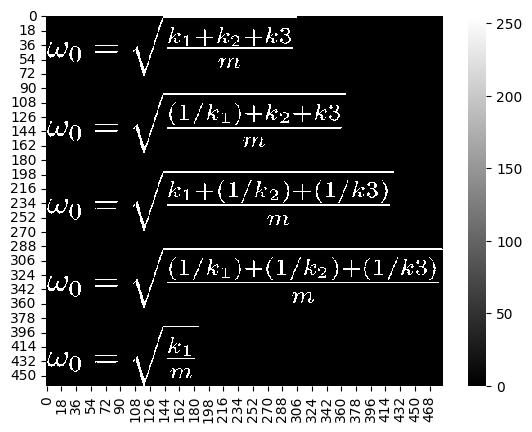

In [34]:
# Load the image
image_path = "output/extracted_question-2.jpg"
img = cv2.imread(image_path)

# Inverse binary threshold grayscale version of image
img_thr = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY_INV)[1]
print(img_thr.shape)

sns.heatmap(img_thr, cmap="gray")
plt.show()

# Count pixels along the y-axis, find peaks
thr_y = 200
y_sum = np.count_nonzero(img_thr, axis=0)
peaks = np.where(y_sum > thr_y)[0]

# Clean peaks
thr_x = 50
temp = np.diff(peaks).squeeze()
idx = np.where(temp > thr_x)[0]
peaks = np.concatenate(([0], peaks[idx+1]), axis=0) + 1

# Save sub-images
for i in np.arange(peaks.shape[0] - 1):
    cv2.imwrite('sub_image_' + str(i) + '.png', img[:, peaks[i]:peaks[i+1]])

In [35]:
for a in np.array([[1, 2, 3], [4, 5, 6]]):
    print(a)

[1 2 3]
[4 5 6]


In [36]:
def getWhiteIntervals(img):
    # Convert to grayscale
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a binary threshold to detect non-white regions
    _, img_thr = cv.threshold(img, 240, 255, cv.THRESH_BINARY_INV)

    intervals = []

    start = None
    end = None

    for c, line in enumerate(img_thr):

        if start is None:
            if np.sum(line) == 0:
                    start = c
        elif end is None:
            if np.sum(line) != 0:
                end = c-1
                intervals.append([start, end])
                start = None
                end = None

    return intervals

def trimWhitespace(image, output_path="trimmed_output.jpg"):

    # Convert to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Apply a binary threshold to detect non-white regions
    _, thresh = cv.threshold(gray, 240, 255, cv.THRESH_BINARY_INV)

    # Find contours of the non-white regions
    contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get bounding box of the largest contour
        x, y, w, h = cv.boundingRect(np.concatenate(contours))

        # Crop the image using the bounding box
        cropped = image[y:y+h, x:x+w]

        # Save or return the cropped image
        cv.imwrite(output_path, cropped)
        return cropped

def splitLines(img):
    needle_height = img.shape[0]
    needle_width = img.shape[1]
    
    intervals = getWhiteIntervals(img)
    intervals.insert(0, [-1, 0])
    intervals.append([needle_height, -1])

    quest_intervals = [[intervals[inter][1], intervals[inter+1][0]] for inter in range(len(intervals)-1)]

    splitted_img = []

    for inter in quest_intervals:
        img_ = img[inter[0]:inter[1], 0:needle_width]
        img_ = trimWhitespace(img_)
        splitted_img.append(img_)

    return splitted_img


In [37]:
image_path = "output/extracted_question-2.jpg"
img = cv2.imread(image_path, cv.IMREAD_COLOR)

intervals = getWhiteIntervals(img)

In [38]:
intervals = getWhiteIntervals(img)
intervals.insert(0, [-1, 0])
intervals.append([0, -1])
display(intervals)

intervals = [[intervals[inter][1], intervals[inter+1][0]] for inter in range(len(intervals)-1)]
intervals

[[-1, 0], [75, 96], [172, 193], [269, 290], [366, 387], [0, -1]]

[[0, 75], [96, 172], [193, 269], [290, 366], [387, 0]]

In [39]:
imgs = splitLines(img)

for c, img in enumerate(imgs):
    # sns.heatmap(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cmap="gray")
    # plt.show()
    cv.imwrite(f"file-{c}.jpg", img)

In [40]:
needle_height = img.shape[0]
needle_width = img.shape[1]

sns.heatmap(cv.cvtColor(img[0:intervals[0][0], 0:needle_width], cv.COLOR_BGR2GRAY))

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
